# GloVe (Assignment)

Assignment Instruction

Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:
1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria:
0:  Not done
1: ok
2: with comments / explanation / figures just like how Chaky explain thing.....

I will use same assignment 1 based. (Only add GloVe and compare)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import time

In [2]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 1. Load data

In [3]:
# Load tokeniser from SpaCy. I will use only small version.

tokeniser = spacy.load("en_core_web_sm")

In [4]:
#define corpus //I will use data that posted in classroom one.

corpus = []

with open('questions-words.txt') as f:
    while True:
        line = f.readline()
        if not line:
            break
        corpus.append(line.strip())
print(corpus[:5])
corpus_tokenised = []
for i in range(len(corpus)):
    corpus_tokenised.append([str(token) for token in tokeniser([c for c in corpus][i])])

[': capital-common-countries', 'Athens Greece Baghdad Iraq', 'Athens Greece Bangkok Thailand', 'Athens Greece Beijing China', 'Athens Greece Berlin Germany']


In [5]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenised)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Athens"]

59

In [6]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[50]

'harder'

### 2. Prepare train data

In [7]:
skipgrams = []

#for each corpus
for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:50] #shows only sample 50 elements

[['-', ':'],
 ['-', 'capital'],
 ['-', 'common'],
 ['-', '-'],
 ['common', 'capital'],
 ['common', '-'],
 ['common', '-'],
 ['common', 'countries'],
 ['-', ':'],
 ['-', 'city'],
 ['-', 'in'],
 ['-', '-'],
 ['in', 'city'],
 ['in', '-'],
 ['in', '-'],
 ['in', 'state'],
 ['-', ':'],
 ['-', 'gram1'],
 ['-', 'adjective'],
 ['-', '-'],
 ['adjective', 'gram1'],
 ['adjective', '-'],
 ['adjective', '-'],
 ['adjective', 'to'],
 ['-', '-'],
 ['-', 'adjective'],
 ['-', 'to'],
 ['-', '-'],
 ['to', 'adjective'],
 ['to', '-'],
 ['to', '-'],
 ['to', 'adverb'],
 ['-', ':'],
 ['-', 'gram5'],
 ['-', 'present'],
 ['-', '-'],
 ['present', 'gram5'],
 ['present', '-'],
 ['present', '-'],
 ['present', 'participle'],
 ['-', ':'],
 ['-', 'gram6'],
 ['-', 'nationality'],
 ['-', '-'],
 ['nationality', 'gram6'],
 ['nationality', '-'],
 ['nationality', '-'],
 ['nationality', 'adjective'],
 ['-', ':'],
 ['-', 'gram7']]

In [8]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = []
            for j in np.ravel([sent[i - 2:i],sent[i + 1: i + 3]]):
                outside_words.append(word2index[j])  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [9]:
input, label = random_batch(10, corpus_tokenised)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[608],
       [710],
       [608],
       [842],
       [747],
       [608],
       [340],
       [608],
       [608],
       [732]])


### 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [10]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenised))
# word_count # Showing word count

In [11]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

78244

In [12]:
z = 0.001  #scaling up low frequency terms
unigram_table = []

# create loop for the P(w) formula
for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** (3/4)
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

### 4. Negative sampling

In [13]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [14]:
import random

def negative_sampling(targets, unigram_table, k):
    
    batch_size = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)

In [15]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenised)

input_batch, label_batch

(array([[608],
        [713]]),
 array([[608],
        [747]]))

In [16]:
# Convert to Tensor

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [17]:
num_neg = 10  # I will try 10 as in the paper.
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [18]:
neg_samples.shape # shape is (batch_size, num_neg)

torch.Size([2, 10])

### 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [19]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_centre_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, centre_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        centre_embed  = self.embedding_centre_word(centre_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

In [20]:
input, label = random_batch(batch_size, corpus_tokenised)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [21]:
emb_size = 10 # I will try on 10.
voc_size = len(vocabs)
modelSkNeg = SkipgramNeg(voc_size, emb_size)

In [22]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [23]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [24]:
loss = modelSkNeg(input_tensor, label_tensor, neg_tensor)
loss

tensor(0.3627, grad_fn=<NegBackward0>)

### 4. Training

In [25]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelSkNeg      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(modelSkNeg.parameters(), lr=0.001)

In [26]:
num_epochs = 5000
startp = time.time()
for epoch in range(num_epochs):

    #get random batch
    start = time.time()
    input_batch, label_batch = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = modelSkNeg
    loss = modelSkNeg(input_batch, label_batch, neg_batch)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}m {epoch_secs}s")
endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}m {secs}s")

Epoch 1000 | Loss: 0.002662 | Time: 0m 0s
Epoch 2000 | Loss: 0.000000 | Time: 0m 0s
Epoch 3000 | Loss: 0.000000 | Time: 0m 0s
Epoch 4000 | Loss: 0.000000 | Time: 0m 0s
Epoch 5000 | Loss: 0.000000 | Time: 0m 0s
Process Time: 0m 46s


### 5. Plot the embeddings

In [27]:
Athens = torch.LongTensor([word2index['Athens']])
Athens

tensor([59])

In [28]:
Athens_centre_embed = modelSkNeg.embedding_centre_word(Athens)
Athens_outside_embed = modelSkNeg.embedding_outside_word(Athens)

Athens_embed = (Athens_centre_embed + Athens_outside_embed) / 2
Athens_embed

tensor([[-2.3589, -2.9173,  1.4287, -1.5105, -4.0324, -1.5304,  1.0376,  2.3497,
         -1.8660,  0.8379]], grad_fn=<DivBackward0>)

In [29]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelSkNeg.embedding_centre_word(word)
    outside_embed = modelSkNeg.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [30]:
print(get_embed('Athens'))

(-2.358924388885498, -2.917296886444092)


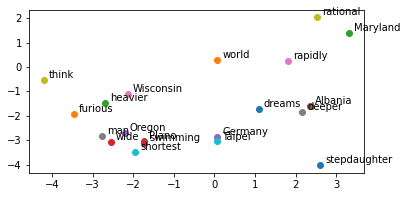

In [31]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### 6. Try on CBOW

In [32]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenised)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Athens"]

59

In [33]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[50]

'harder'

#### Prepare train data

I use same way but change the variable to not making myself get confused.

In [34]:
CBOW = []

#for each corpus
for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for o in outside_words:
            CBOW.append([center_word, o])

CBOW[:50] #shows only sample 50 elements

[['-', ':'],
 ['-', 'capital'],
 ['-', 'common'],
 ['-', '-'],
 ['common', 'capital'],
 ['common', '-'],
 ['common', '-'],
 ['common', 'countries'],
 ['-', ':'],
 ['-', 'city'],
 ['-', 'in'],
 ['-', '-'],
 ['in', 'city'],
 ['in', '-'],
 ['in', '-'],
 ['in', 'state'],
 ['-', ':'],
 ['-', 'gram1'],
 ['-', 'adjective'],
 ['-', '-'],
 ['adjective', 'gram1'],
 ['adjective', '-'],
 ['adjective', '-'],
 ['adjective', 'to'],
 ['-', '-'],
 ['-', 'adjective'],
 ['-', 'to'],
 ['-', '-'],
 ['to', 'adjective'],
 ['to', '-'],
 ['to', '-'],
 ['to', 'adverb'],
 ['-', ':'],
 ['-', 'gram5'],
 ['-', 'present'],
 ['-', '-'],
 ['present', 'gram5'],
 ['present', '-'],
 ['present', '-'],
 ['present', 'participle'],
 ['-', ':'],
 ['-', 'gram6'],
 ['-', 'nationality'],
 ['-', '-'],
 ['nationality', 'gram6'],
 ['nationality', '-'],
 ['nationality', '-'],
 ['nationality', 'adjective'],
 ['-', ':'],
 ['-', 'gram7']]

In [35]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = []
            for j in np.ravel([sent[i - 2:i],sent[i + 1: i + 3]]):
                outside_words.append(word2index[j])  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [36]:
input, label = random_batch(10, corpus_tokenised)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[189],
       [710],
       [608],
       [608],
       [608],
       [340],
       [608],
       [747],
       [608],
       [608]])


#### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [37]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenised))
# word_count # Showing word count

In [38]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

78244

In [39]:
z = 0.001  #scaling up low frequency terms
unigram_table = []

# create loop for the P(w) formula
for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** (3/4)
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
# Counter(unigram_table)

#### Negative sampling

In [40]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [41]:
import random

def negative_sampling(targets, unigram_table, k):
    
    batch_size = targets.shape[0]
    neg_samples = []
    
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)

According to quiz, Skipgram use centre to predict context but CBOW use context to predict centre, I just flip label and input on this step.

In [42]:
batch_size = 2
label_batch, input_batch = random_batch(batch_size, corpus_tokenised)

input_batch, label_batch

(array([[608],
        [608]]),
 array([[608],
        [517]]))

In [43]:
# Convert to Tensor

input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [44]:
num_neg = 10  # I will try 10 as in the paper.
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [45]:
neg_samples.shape # shape is (batch_size, num_neg)

torch.Size([2, 10])

#### Model

In [46]:
# get inspired from https://github.com/jeffchy/pytorch-word-embedding/blob/master/CBOW.py

class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_centre_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, centre_words, outside_words, negative_words):
        
        centre_embed  = self.embedding_centre_word(centre_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(centre_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

I flip label and input on this step also.

In [47]:
label, input = random_batch(batch_size, corpus_tokenised)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [48]:
emb_size = 10 # I will try on 10.
voc_size = len(vocabs)
modelCB = CBOW(voc_size, emb_size)

In [49]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [50]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [51]:
loss = modelCB(input_tensor, label_tensor, neg_tensor)
loss

tensor(2.5191, grad_fn=<NegBackward0>)

#### Training

In [52]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelCB      = CBOW(voc_size, emb_size)

optimizer  = optim.Adam(modelCB.parameters(), lr=0.001)

In [53]:
num_epochs = 5000
startp = time.time()
for epoch in range(num_epochs):
    start = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = modelCB
    loss = modelCB(input_batch, label_batch, neg_batch)
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}m {epoch_secs}s")
endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}m {secs}s")

Epoch 1000 | Loss: 0.009406 | Time: 0m 0s
Epoch 2000 | Loss: 0.000000 | Time: 0m 0s
Epoch 3000 | Loss: 0.000000 | Time: 0m 0s
Epoch 4000 | Loss: 0.000000 | Time: 0m 0s
Epoch 5000 | Loss: -0.000000 | Time: 0m 0s
Process Time: 0m 47s


#### Plot the embeddings

In [54]:
Athens = torch.LongTensor([word2index['Athens']])
Athens

tensor([59])

In [55]:
Athens_centre_embed = modelCB.embedding_centre_word(Athens)
Athens_outside_embed = modelCB.embedding_outside_word(Athens)

Athens_embed = (Athens_centre_embed + Athens_outside_embed) / 2
Athens_embed

tensor([[ 2.7279,  1.9343,  2.4300,  2.6567,  0.8942, -2.2976,  2.6259,  1.8140,
         -3.0747, -1.5097]], grad_fn=<DivBackward0>)

In [56]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelCB.embedding_centre_word(word)
    outside_embed = modelCB.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [57]:
print(get_embed('Athens'))

(2.727918863296509, 1.9342565536499023)


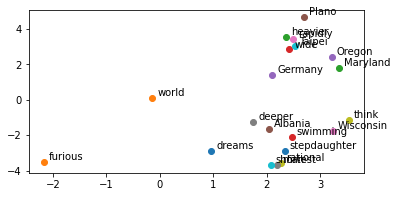

In [58]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Normal Skipgram

In [59]:
#delete dupliAthense word define as vocabs, also include unknow as <UNK>.
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenised)))
vocabs.append('<UNK>') # to let '<UNK>' become the last.
word2index = {v: idx+1 for idx, v in enumerate(vocabs)} #plus one to shift value in word index to assign <UNK>'s value to 0 without dupliAthension with others.
word2index['<UNK>'] = 0

#Let check word to index's value
word2index["Athens"]

59

In [60]:
# Create index to word
index2word = {v:k for k, v in word2index.items()}

index2word[50]

'harder'

In [61]:
skipgrams = []

#for each corpus
for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        center_word = sent[i]
        outside_words = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for o in outside_words:
            skipgrams.append([center_word, o])

# skipgrams[:50] #shows only sample 50 elements

In [62]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = []
            for j in np.ravel([sent[i - 2:i],sent[i + 1: i + 3]]):
                outside_words.append(word2index[j])  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [63]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_centre_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, centre_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size, 1)
        #all_vocabs: (batch_size, voc_size)
        
        #convert them into embedding
        centre_word_embed  = self.embedding_centre_word(centre_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(centre_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(centre_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [64]:
input, label = random_batch(10, corpus_tokenised)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[608],
       [608],
       [608],
       [710],
       [608],
       [509],
       [747],
       [233],
       [461],
       [608]])


#### Model


In [65]:
batch_size = 2

def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 939])

In [66]:
input, label = random_batch(batch_size, corpus_tokenised)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [67]:
emb_size = 10 # I will try on 10.
voc_size = len(vocabs)
modelSk = Skipgram(voc_size, emb_size)

In [68]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [69]:
loss = modelSk(input_tensor, label_tensor, all_vocabs)
loss

tensor(10.7779, grad_fn=<NegBackward0>)

#### Training

In [70]:
voc_size   = len(vocabs)
batch_size = 2
emb_size   = 10
modelSk      = Skipgram(voc_size, emb_size)

optimizer  = optim.Adam(modelSk.parameters(), lr=0.001)

In [71]:
num_epochs = 3000 # I tried 5000 and it was nan. IDK why.
startp = time.time()
#for epoch
for epoch in range(num_epochs):
    start = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    loss = modelSk(input_batch, label_batch, all_vocabs)
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {epoch_mins}m {epoch_secs}s")

endp = time.time()
mins, secs = epoch_time(startp, endp)
print(f"Process Time: {mins}m {secs}s")

Epoch 1000 | Loss: 2.492503 | Time: 0m 0s
Epoch 2000 | Loss: 1.796940 | Time: 0m 0s
Epoch 3000 | Loss: 1.329995 | Time: 0m 0s
Process Time: 0m 28s


#### Plot the embeddings

In [72]:
Athens = torch.LongTensor([word2index['Athens']])
Athens

tensor([59])

In [73]:
Athens_centre_embed = modelSk.embedding_centre_word(Athens)
Athens_outside_embed = modelSk.embedding_outside_word(Athens)

Athens_embed = (Athens_centre_embed + Athens_outside_embed) / 2
Athens_embed

tensor([[-0.2706, -1.9972, -2.3916,  0.8262, -2.0140,  1.9555,  1.0224, -1.4896,
         -2.5802, -2.1683]], grad_fn=<DivBackward0>)

In [74]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = modelSk.embedding_centre_word(word)
    outside_embed = modelSk.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [75]:
print(get_embed('Athens'))

(-0.27064716815948486, -1.9972343444824219)


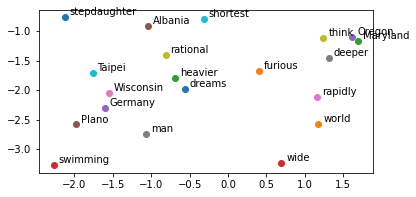

In [76]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

# 8. GloVe

In [77]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus_tokenised)))
vocab[:5]

['stepdaughter', 'furious', 'heavier', 'wide', 'Germany']

In [78]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [79]:
#vocab size
voc_size = len(vocab)
print(voc_size)

938


In [80]:
#append UNK
vocab.append('<UNK>')

In [81]:
word2index['<UNK>'] = 0

In [82]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

### Build Co-occurence Matrix X

In [83]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
# X_i

In [84]:
# Make skip gram of one size window
skip_grams = []

for sent in corpus_tokenised:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(2, len(sent) - 2): # start from 1 to second last but we use window size of 2, then first centre word should be at index 2
        target = sent[i]
        context = np.ravel([sent[i - 2:i],sent[i+1: i + 3]])  # window_size = 2
        for w in context:
            skip_grams.append((target, w))

skip_grams[:5]

[('-', ':'),
 ('-', 'capital'),
 ('-', 'common'),
 ('-', '-'),
 ('common', 'capital')]

In [85]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('-', ':'): 7,
         ('-', 'capital'): 1,
         ('-', 'common'): 1,
         ('-', '-'): 9,
         ('common', 'capital'): 1,
         ('common', '-'): 2,
         ('common', 'countries'): 1,
         ('-', 'city'): 1,
         ('-', 'in'): 1,
         ('in', 'city'): 1,
         ('in', '-'): 2,
         ('in', 'state'): 1,
         ('-', 'gram1'): 1,
         ('-', 'adjective'): 2,
         ('adjective', 'gram1'): 1,
         ('adjective', '-'): 2,
         ('adjective', 'to'): 1,
         ('-', 'to'): 1,
         ('to', 'adjective'): 1,
         ('to', '-'): 2,
         ('to', 'adverb'): 1,
         ('-', 'gram5'): 1,
         ('-', 'present'): 1,
         ('present', 'gram5'): 1,
         ('present', '-'): 2,
         ('present', 'participle'): 1,
         ('-', 'gram6'): 1,
         ('-', 'nationality'): 1,
         ('nationality', 'gram6'): 1,
         ('nationality', '-'): 2,
         ('nationality', 'adjective'): 1,
         ('-', 'gram7'): 1,
         ('-', 'pas

In [86]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [87]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Prepare train data

In [88]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [89]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[607]
 [607]]
Target:  [[746]
 [607]]
Cooc:  [[0.69314718]
 [2.30258509]]
Weighting:  [[0.05318296]
 [0.17782794]]


### Model

In [90]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

### Training

In [91]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
modelGl          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelGl.parameters(), lr=0.001)

In [92]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [93]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = modelGl(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 0.000498 | time: 0m 0s
Epoch: 2000 | cost: 0.001753 | time: 0m 0s
Epoch: 3000 | cost: 0.054820 | time: 0m 0s
Epoch: 4000 | cost: 0.000638 | time: 0m 0s
Epoch: 5000 | cost: 0.000216 | time: 0m 0s


### Plotting the embeddings

In [94]:
#list of vocabs
vocab[:10]

['stepdaughter',
 'furious',
 'heavier',
 'wide',
 'Germany',
 'Plano',
 'rapidly',
 'deeper',
 'rational',
 'Taipei']

In [95]:
word = vocab[0]

In [96]:
#numericalization
id = word2index[word]
id

0

In [97]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [98]:
#get the embedding by averaging
v_embed = modelGl.embedding_v(id_tensor)
u_embed = modelGl.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.1092,  0.4419]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.1808,  1.4376]], grad_fn=<EmbeddingBackward0>))

In [99]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.9397, grad_fn=<SelectBackward0>)

In [100]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = modelGl.embedding_v(id_tensor)
    u_embed = modelGl.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

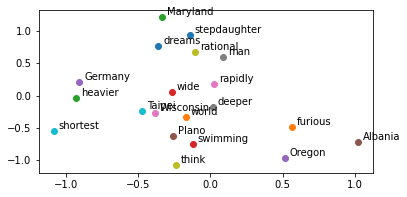

In [101]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Compare them based on syntactic accuracy and semantic accuracy

TBH, I am not sure how to do this, but I will try anyway.

In [102]:
corpus_tokenised[1:6]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland']]

In [103]:
modelSkNeg, modelSk, modelCB, modelGl

(SkipgramNeg(
   (embedding_centre_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
   (logsigmoid): LogSigmoid()
 ),
 Skipgram(
   (embedding_centre_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
 ),
 CBOW(
   (embedding_centre_word): Embedding(939, 10)
   (embedding_outside_word): Embedding(939, 10)
   (logsigmoid): LogSigmoid()
 ),
 GloVe(
   (embedding_v): Embedding(938, 2)
   (embedding_u): Embedding(938, 2)
   (v_bias): Embedding(938, 1)
   (u_bias): Embedding(938, 1)
 ))

In [104]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    for sent in corpus:
        for i in range(2, len(sent) - 2): #start from 2 to third last for window size = 2
            centre_word = word2index[sent[i]]
            outside_words = []
            for j in np.ravel([sent[i - 2:i],sent[i + 1: i + 3]]):
                outside_words.append(word2index[j])  #window_size = 2
            for o in outside_words:
                skipgrams.append([centre_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

In [105]:
import math

def random_batchGl(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

#### syntactic accuracy

In [106]:
num_epochs = 3000 # I tried 5000 and it was nan. IDK why.
startp = time.time()
lossSk = 0
lossSkNeg = 0
lossCB = 0
lossGl = 0
batch_size = 2
#for epoch
for epoch in range(num_epochs):
    input_batch, label_batch = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    input_batchG, target_batchG, cooc_batch, weighting_batch = random_batchGl(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batchG  = torch.LongTensor(input_batch)
    target_batchG = torch.LongTensor(target_batch)
    cooc_batch   = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    lossSk += modelSk(input_batch, label_batch, all_vocabs)
    lossSkNeg += modelSkNeg(input_batch, label_batch, all_vocabs)
    lossCB += modelCB(input_batch, label_batch, all_vocabs)
    lossGl += modelGl(input_batchG, target_batchG, cooc_batch, weighting_batch)
print(f'loss Skipgram: {lossSk/num_epochs}\nloss Skipgram Neg: {lossSkNeg/num_epochs}\nloss CBOW: {lossCB/num_epochs}\nloss GloVe: {lossGl/num_epochs}')

loss Skipgram: 17.477577209472656
loss Skipgram Neg: 1690.981689453125
loss CBOW: 1345.9429931640625
loss GloVe: 0.3253587484359741


#### semantic accuracy

In [107]:
num_epochs = 3000 # I tried 5000 and it was nan. IDK why.
startp = time.time()
lossSk = 0
lossSkNeg = 0
lossCB = 0
lossGl = 0
batch_size = 2
#for epoch
for epoch in range(num_epochs):
    label_batch, input_batch  = random_batch(batch_size, corpus_tokenised)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    target_batchG, input_batchG, cooc_batch, weighting_batch = random_batchGl(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batchG  = torch.LongTensor(input_batch)
    target_batchG = torch.LongTensor(target_batch)
    cooc_batch   = torch.FloatTensor(cooc_batch)
    weighting_batch = torch.FloatTensor(weighting_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = modelSk
    lossSk += modelSk(input_batch, label_batch, all_vocabs)
    lossSkNeg += modelSkNeg(input_batch, label_batch, all_vocabs)
    lossCB += modelCB(input_batch, label_batch, all_vocabs)
    lossGl += modelGl(input_batchG, target_batchG, cooc_batch, weighting_batch)
print(f'loss Skipgram: {lossSk/num_epochs}\nloss Skipgram Neg: {lossSkNeg/num_epochs}\nloss CBOW: {lossCB/num_epochs}\nloss GloVe: {lossGl/num_epochs}')

loss Skipgram: 19.66742515563965
loss Skipgram Neg: 1495.14404296875
loss CBOW: 1604.5977783203125
loss GloVe: 0.4675363004207611


||Syntactic|Semantic|
|:--|:--|:--|
|Skipgram|17.477577209472656|19.66742515563965|
|Skipgram Neg|1690.981689453125|1495.14404296875|
|CBOW|1345.9429931640625|1604.5977783203125|
|GloVe|0.3253587484359741|0.4675363004207611|